# 3. Statistical Inference and Frequentist A/B Testing
If you went through my **Introduction to Statistics** post, then you are finally arriving at the payoff for all of our work: **statistical inference**. Statistical inference is used a wide variety of ways, but for now we will informally describe it as follows:

> Statistics cannot prove anything with certainty. Instead, statistical inference derives its power from observing some pattern or outcome and then using probability to determine the most likely explanation for that outcome. 

To demonstrate with an extreme example, imagine that you have a friend who makes you the following bet: he has a 10 sided die, and bets you that if he rolls a 9 you pay him 1000 and if he rolls anything else you pay him 1000. He then proceeds to roll eight 9's in a row, forcing you to pay him 8000. One possibility is that he was incredibly lucky, the other that he cheated. The probability of rolling eight 9's in a row with a 10 sided die is one in one hundred million. Again, there may be no way to prove with 100% certainty that he cheated, but we should definitely investigate the die. 

The intuition that you had above that told you he most likely cheated, in a sense statistical inference is the building of that intuition into a mathematical framework, allowing us to quantify probabilities surrounding decisions. 

Let's consider a much more important scenario that comes into play frequently in the fields of medicine and epidemiology. Imagine there is a new heart medication on the market, and there is a **randomized controlled trial** to determine its effectiveness. Let's say that 52 out of 100 patients taking the new medication showed improvement compared to 49 of 100 patients who had the placebo (plot on left). In this case we would not be able to immediately conclude that the new drug is effective, since it easily _explained_ by chance variation between the two groups.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc, animation
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML

sns.set(style="white", palette="husl")
sns.set_context("talk")
sns.set_style("ticks")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

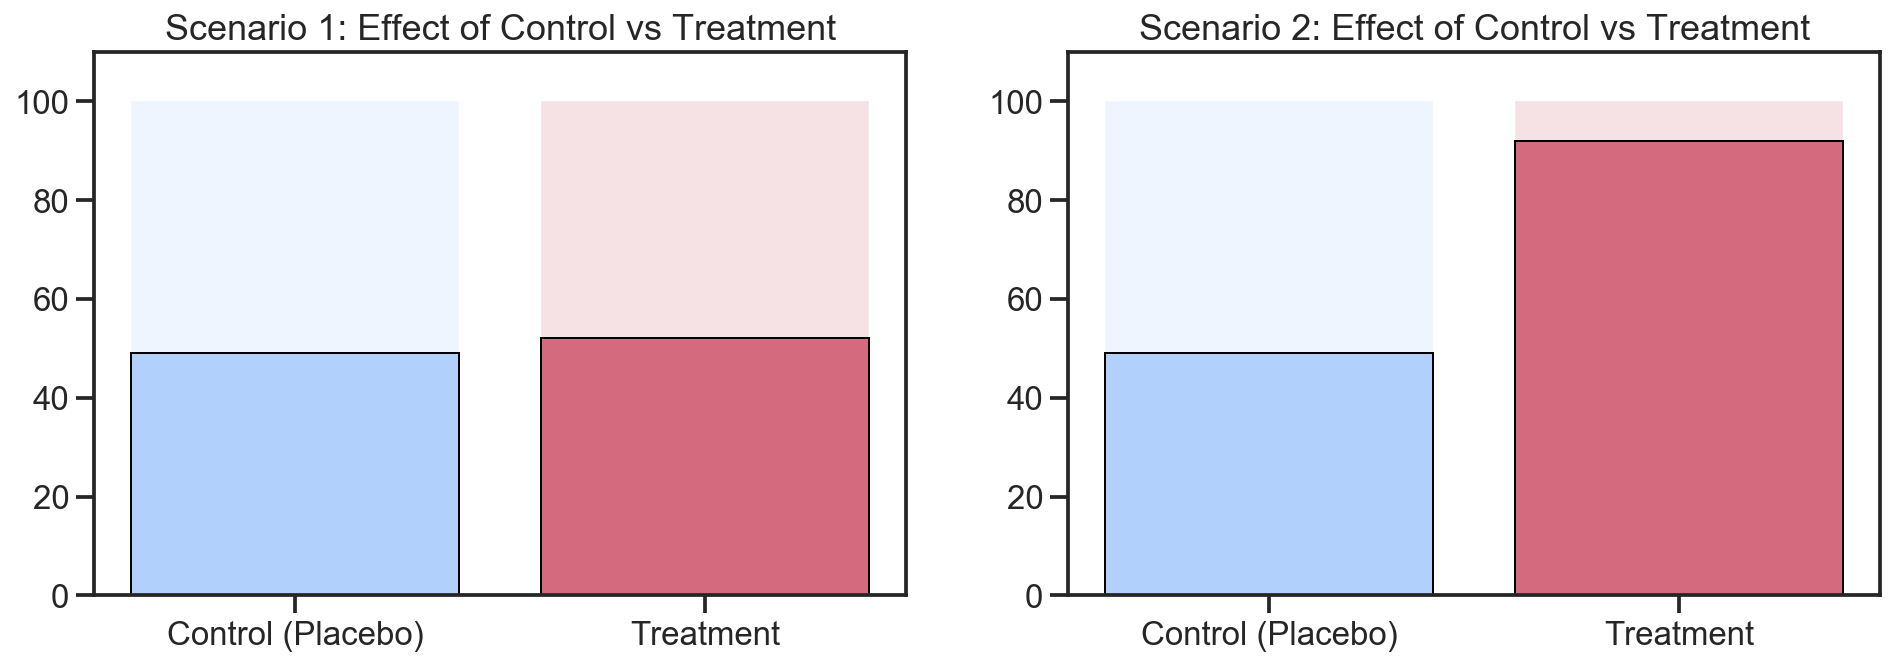

In [47]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.bar(
    x=['Control (Placebo)','Treatment'],
    height=[100,100], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    linewidth=1,
    alpha=0.2
)
plt.bar(
    x=['Control (Placebo)','Treatment'],
    height=[49,52], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    edgecolor="black",
    linewidth=1,
)
plt.title("Scenario 1: Effect of Control vs Treatment")
plt.ylim(0,110)

plt.subplot(1, 2, 2)
plt.bar(
    x=['Control (Placebo)','Treatment'],
    height=[100,100], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    linewidth=1,
    alpha=0.2
)
plt.bar(
    x=['Control (Placebo)','Treatment'],
    height=[49,92], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    edgecolor="black",
    linewidth=1,
)
plt.title("Scenario 2: Effect of Control vs Treatment")
plt.ylim(0,110)

plt.show()

Now, suppose instead that 92 out of 100 patients taking the medication showed improvement, compared to only 49 of 100 in the control group (plot on right). It is still possible that the result is unrelated to the drug; the patients in the treatment group may have just been very lucky, and of course the experiment may have missed controlling for a **confounder**. However, that is now a _much less likely explanation_. In the language of statistical inference, the following would most likely be concluded:

1. If the experimental drug has no effect, we would rarely see this amount of variation in outcomes between those who are receiving the drug and those who are receiving the placebo.
2. It is therefore highly improbably that the drug has no positive effect.
3. The alternative, and more likely, explanation for the pattern of data observed is that the experimental drug has a positive effect. 

This is the payoff for all of our work in the introduction to statistics post! The main goal surrounding statistics, and really all of applied mathematics for that matter, is _not_ to just go through an array of calculations just to seem smart-no, it is to gain insight into the world around us! In the case of statistics, it is used to gain insight into social phenomena, to determine confidence around certain measurements and experiments, to ensure that experiments are conducted in a valid manner. To summarize:

> Statistics, and in particular statistical inference, are used in order to gain _insight_ into the world around us. They can take a complex and intractable universe and find underlying trends that humans can understand and use advantageously. 

## 1. Hypothesis testing
As we stated earlier, statistics alone cannot _prove_ anything. What it allows us to do is accept or reject an explanation based on it's relative likelihood of occuring. Put more formally, when performing any statistical inference we start by defining an explicit or implicit **null hypothesis**. This is our starting assumption that will either be accepted or rejected based on our analysis. Along side our null hypothesis is the **alternative hypothesis**, which based on logic is accepted if our null hypothesis is rejected. To make this more concrete, here is an example:

* **Null Hypothesis**: The new drug is no more effective at preventing malaria than a placebo
* **Alternative Hypothesis**: The new drug can help prevent malaria. 

We then would have our actual data (which can be observational, but in scenarios like this it is frequently gathered via a randomized controlled trial. In the case of the RCT, let's say that the group receiving the experimental drug has far fewer cases of malaria than the control group. This would be extremely unlikely if the drug had no medical impact. Hence, we would _reject_ the null hypothesis that the drug is no more effective than a placebo, and hence we accept the alternative hypothesis. 

To be clear, semantics do play a role here. We have not actually _proven_ our alternative hypothesis; in reality we have merely failed to reject our _null hypothesis_. 

Additionally, you may be wondering:

> How do we know if the difference between two quantities is **significant**? 

That is a fantastic question, and will be something to keep in mind throughout all of my posts on statistics, AB testing, and Bayesian Inference. In order to be significant we can say that the difference between two quantities _probably is not due to chance_. 

On the other hand, if we are talking about a difference **not being significant**, then we are saying that there is not enough evidence to say that an observed difference between two quantities is not random. _Or_, we could also be saying that the difference is _smaller than we care about_. 

### 1.1 Hypothesis Testing - High Level Overview
With the above understood, I want to give an overview of hypothesis testing from a different vantage point. I think that it is relatively clear that we are asking the _qualitative_ question: 

> Is this difference real (or just statistical noise)?

However, the goal of hypothesis testing is reframe this into a _quantitative/mathematical_ question:

> What is the **probability** that the difference we are observing is due to chance? 

In order to do this we will perform a **proof by contradiction**: We start by assuming the _null hypothesis_, which states that their is no difference and that what we are seeing is just random, and then we perform a hypothesis test in order to find the _probability of the null hypothesis_. This probability is also known as the **p-value**. The _p-value_ is defined as:

> **p-value**: The probability that the null hypothesis is true. 

In general, we want to arrive at a _p-value_ of less than 0.05, which translates to: there is only a 5% chance that two identical distributions could have produced these results. Now, before we go through a full example of hypothesis testing, we need to go over some background surrounding **confidence intervals**.

## 2. Confidence Intervals

### 2.1 Parameter Estimation - Bernoulli Distribution
Consider the following situation: you run an e-commerce site, and you want to track and measure the _click-through-rate_ (CTR) for different users. The CTR is a metric that can either be yes or no, meaning the user either entered the website, found an item, went to the checkout and completed the purchase (_buy_), or they did not (_don't buy_). 

This is not a Gaussian Distribution, rather it is more like that of a coin toss, meaning there are two possible outcomes-namely a **bernoulli distribution**:

$$P(n) = p^n (1-p)^{1-n}$$

Where $p$ is the probability of buying something, $p = P(buy)$. Let's say that we have historical data related to five users:

|User|Buy/Not buy|
|----|----|
|1|Buy|
|2|Not Buy|
|3|Not Buy|
|4|Buy|
|5|Not Buy|

If we know that $P(buy) = p$, and there are only two outcomes, then it follows that:

$$P(not \; buy) = 1 - p$$

We also know that these events are **independent** and **idenitically distributed** (IID); in other words, person 1 buying/not buying does not effect the outcome of person 4. Finally, keep in mind that the bernoulli distribution only has one parameter, $p$, while the gaussian distribution has two parameters $\mu$ and $\sigma^2$.

With all of the above information, we want to answer the following question:

> What is the total likelihood of our observations in the above table?

Well, based on the Bernoulli distribution, we can say that the total likelihood is equal to:

$$L(2 \; buy, 3 \; not \;buy) = p^2 (1-p)^3 = P(buy)P(not \; buy)P(not \; buy)P(buy)P(not \; buy)$$

Above, we were able to multiply the probabilities because they were independent events. This can be generalized as:

$$L(N_{buy}, N_{!buy}) = p^{N_{buy}} (1-p)^{N_{!buy}}$$

Keep in mind that we do _not_ know $p$ yet. So, at this point we cannot calculate the total likelihood. In order to do so, we must answer the following question first:

> What is the **maximum likelihood estimate** of $p$, based on the data that we have collected?

For more information on maximum likelihood estimation see my post in the mathematics section, but here is a brief overview: we use maximum likelihood estimation in order to estimate the **parameter** (in this case $p$) that maximize the likelihood of observing the data that we did. 

Visually, if we iterate over all values of $p$ from $[0,1]$, plugging into our bernoulli equation:

$$L(N_{buy} = 2, N_{!buy} = 3) =  p^2 (1-p)^3$$

$$L(data) =  p^2 (1-p)^3$$

We end up with:

In [ ]:
lower_bound = 0
upper_bound = 1
length = 2000

plt.ioff()                          

fig = plt.figure(figsize=(12, 5), dpi=150)       
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_ylabel("Probability", fontsize=20)
ax1.set_title("Bernoulli Distribution: Buy vs. Not Buy", pad="10")

ax2.set_title(r"Total Likelihood of Observations vs. $p$", pad="10")
ax2.set_ylabel("Total Likelihood of Observations", fontsize=20)
ax2.axhline(y=0, color='grey')
ax2.axvline(x=0, color='grey')
ax2.axvline(x=0.4, color=sns.xkcd_rgb["greenish"], linestyle="dashed") # MLE line
ax2.set_xlabel("$p$", fontsize=20)


def mle(p):
    return np.power(p, 2)*np.power(1-p,3)

rects = ax1.bar(
    x=[r"P(Buy) = $p$",r"P(Not Buy) = $1-p$"],
    height=[0,100], 
    color=[sns.xkcd_rgb["powder blue"],sns.xkcd_rgb["pinkish"]],
    linewidth=1,
    alpha=0.2,
    edgecolor="black"
)
mle_line = ax1.axhline(y=0.4, color=sns.xkcd_rgb["greenish"], linestyle="dashed") # MLE line

ax_mle, = ax2.plot(0, 0, lw=3, c=sns.xkcd_rgb["red"])                         # Initialize plot object for distance
marker1, = ax2.plot(lower_bound, lower_bound, 'or')

def animate(current_p):
    p = np.linspace(lower_bound, current_p, length)
    rects[0].set_height(current_p)
    rects[1].set_height(1 - current_p)
              
    ax_mle.set_data(p, mle(p))             
    marker1.set_data(current_p, mle(current_p))

    return rects, ax_mle

def init():
    ax1.set_ylim(0, 1) 
    ax2.set_xlim(0, 1)                               # Initialize x and y limits
    ax2.set_ylim(0, 0.05) 
    return ax_mle,

""" Define steps and create animation object """
step = 0.0025
steps = np.arange(lower_bound, upper_bound, step)

plt.tight_layout()

# For rendering html video in cell
# html_video = HTML(
#     animation.FuncAnimation(
#         fig,
#         animate,
#         steps,
#         init_func=init, 
#         interval=25,
#     ).to_html5_video()
# )
# display(html_video)

gif_video = animation.FuncAnimation(
        fig,
        animate,
        steps,
        init_func=init, 
        interval=25,
    )

gif_video.save('mle_estimation.gif', writer='imagemagick')

plt.close()

<img src="https://drive.google.com/uc?id=1r41RLLxYvVbwQpA4j0cENRu0zV7bIaBA" width="800">

From the above visualization it is clear that the value of $p$ which maximize the likelihood of observing the data that we did is $0.4$. This is based on the value where the likelihood plot on the right peaks, namely $p=0.4$. Now, with a little bit of calculus we can solve for this arg max without needing to look a the plot. To do there we want to take the derivative of our likelihood function and set it equal to zero; this way we can find our extrema. 

There is one minor implementation detail I must mention-in order to prevent computational precision issues from arising (these come about due to multiplying together many small probabilities), we will take the $log$ of our likelihood.

$$L(N_{buy}, N_{!buy}) = p^{N_{buy}} (1-p)^{N_{!buy}}$$

$$log \Big\{ L(N_{buy}, N_{!buy}) \Big\} = log \Big\{ p^{N_{buy}} (1-p)^{N_{!buy}}\Big\} = N_{buy} log(p) + N_{!buy} log(1-p)$$

We can then take the derivative and set to 0:

$$\frac{\partial L}{\partial p} = \frac{N_H}{p} - \frac{N_T}{(1-p)} = 0$$

And finally, we can solve for $p$:

$$p = \frac{N_{buy}}{N_{buy} + N_{!buy}}$$

Which, just a quick sanity check we can see that it does indeed result in the value of $p$ that maximizes our total likelihood: 

$$p = \frac{2}{2 + 3} = 0.4$$

And, if we let $Buy = 1$ and $!Buy = 0$ then we can end up with standard formula for the mean:

$$p = \frac{1}{N} \sum_{i=1}^N x_i$$

Now, we have just performed our **parameter estimation** based upon our data, but there is something that may be troubling you. Based on the above methodology, if we had observed 20 people buy and 30 people not buy, we would still end up with a 40% probability $p$ that someone buys. The same can be said if we were to observe 2000 buy and 3000 not buy. 

Yet, intuitively we know that the more observations we have, the more reliable our parameter estimate is, and the less likely it is to be skewed due to random chance. The way that we deal with that in standard **frequentist statistics** is through the use of **confidence intervals**. We will delve into what they are and how they work in the next section, but first I want to go over one more example of parameter estimation concerning the gaussian distribution.

### 2.1 Parameter Estimation - Gaussian Distribution
I would like to pose the following question:

> How do you find the mean of a gaussian distribution?

As we did in the example above, we will again use maximum likelihood estimation. Consider for a moment that we collected one sample from a gaussian distributed data source, which we will call $x$. What is the probability density of that one point? Well, we simply need to plug it into the gaussian distribution formula:

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\big( -\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2}\big)$$

And we will get a single number as a result, the probability density of observing that single sample. Of course in real experiments we will be collecting many samples. Generally, these samples are **IID**, which in this case means:
* **Identically Distributed**: Each sample is generated from a gaussian distribution with the same mean and variance
* **Independent**: The outcome of one sample does not effect the outcome of any other samples. Think of a coin toss. Just because I flip heads on my first try does not mean that I am any more likely to flip heads on the second try. 

This independence also means that if we wanted to know the joint probability of all the sample we have observed, we just multiply the individual probabilities of each sample together:

$$p\big(x_1, x_2,...,x_n\big) = \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} exp\big( -\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2}\big)$$

Now, the equation above is nearly correct for our purposes, we just need to make one final update. Our goal is to the find the mean, $\mu$, of this gaussian. So, we can define the probability of the data as:

$$p\big(x_1, x_2,...,x_n \mid \mu \big) = \prod_{i=1}^N p\big(x_i \mid \mu \big)$$

**Data Likelihood**<br>
The above probability has a name: the **likelihood distribution**. In general terms, the likelihood distribution represents the probability of the observed data, given the parameters. In our case, this is the probability of our observations, given the mean of the gaussian distribution:

$$p(data \mid parameters)$$

Our parameters will depend entirely on what the model is, e.g. Gaussian, Bernoulli, Beta, Gamma, etc. Now the Gaussian does have two parameters, $\mu$ and $\sigma$, but we will focus on $\mu$. 

**Maximum Likelihood**<br>
Now that we have our likelihood, how do we maximize it? In other words, what is the best value for $\mu$ such that our total likelihood of observing our data is maximized. 

In [68]:
def mle_gaussian(x, mu, sigma):
    likelihood_of_data = norm.pdf(x, mu, sigma)
    log_likelihood_of_data = np.log(likelihood_of_data)
    return np.sum(log_likelihood_of_data)

In [69]:
lower_bound = -5
upper_bound = 5
length = 2000

plt.ioff()                          

fig = plt.figure(figsize=(12, 5), dpi=150)       
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax2.set_title(r"Total Likelihood of Observations vs. $\mu$", pad="10")
ax2.set_xlabel(r"$\mu$", fontsize=20)

means = np.linspace(lower_bound, upper_bound, length)
sigma = 1
expected_mean = 1
num_observed_points = 30
observed_data = np.random.normal(expected_mean, sigma, num_observed_points)
x_axis = np.arange(-5, 5, 0.001)

ax2.axvline(x=expected_mean, color=sns.xkcd_rgb["greenish"], linestyle="dashed")

ax_mle, = ax2.plot(0, 0, lw=3, c=sns.xkcd_rgb["red"])                         # Initialize plot object for distance
marker1, = ax2.plot(lower_bound, 0, 'or')
mu = np.array([])
likelihoods = np.array([])

def animate(current_mu):
    # Gaussian Plot - left 
    ax1.clear()
    gaussian_dist = norm.pdf(x_axis, current_mu, sigma)
    ax1.plot(x_axis, gaussian_dist, c=sns.xkcd_rgb["grey"],linewidth=1)
    ax1.fill_between(x_axis, gaussian_dist, color=sns.xkcd_rgb["powder blue"], alpha=0.5)
    ax1.scatter(observed_data, np.zeros(len(observed_data)), c=sns.xkcd_rgb["neon purple"], alpha=0.7, zorder=4)

    ax1.axvline(x=current_mu, color=sns.xkcd_rgb["dusty blue"], linestyle="dashed")
    ax1.axvline(x=expected_mean, color=sns.xkcd_rgb["greenish"], linestyle="dashed")
    ax1.annotate(r"$\mu$ = {}".format(round(current_mu, 2)), [-4.5,0.38], size=18)
    ax1.set_title(r"Gaussian Distribution: Function of $\mu$", pad="10")
    ax1.set_xlabel(r"$x$", fontsize=20)

    # MLE Update - right
    global mu
    global likelihoods
    current_mu_likelihood = mle_gaussian(observed_data, current_mu, sigma)
    mu = np.append(mu, current_mu)
    likelihoods = np.append(likelihoods, current_mu_likelihood)
    ax_mle.set_data(mu, likelihoods)     
    marker1.set_data(current_mu, mle_gaussian(observed_data, current_mu, sigma))

    return ax_gaussian, ax_mle

def init():
    ax1.set_ylim(0, 1) 
    ax2.set_xlim(-5, 5)                               # Initialize x and y limits
    ax2.set_ylim(-650, 0) 
    return ax_gaussian, ax_mle

""" Define steps and create animation object """
step = 0.01
steps = np.arange(lower_bound, upper_bound, step)

plt.tight_layout()

# For rendering html video in cell
# html_video = HTML(
#     animation.FuncAnimation(
#         fig,
#         animate,
#         steps,
#         init_func=init, 
#         interval=25,
#     ).to_html5_video()
# )
# display(html_video)
gif_video = animation.FuncAnimation(
        fig,
        animate,
        steps,
        init_func=init, 
        interval=25,
    )
gif_video.save('mle_gaussian_estimation.gif', writer='imagemagick')

plt.close()

<img src="https://drive.google.com/uc?id=1cyHP0ZF8-tt6Ng4qrZSX5iA_yhd03MRa" width="800">